## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Notebook At a Glance</p>

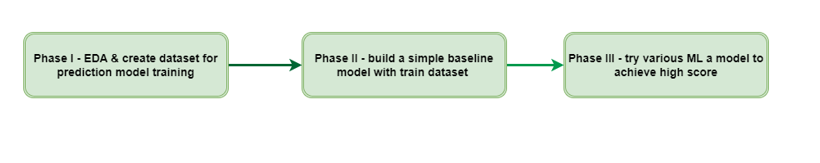

> #### In phase I, the main purpose is to make a dataset that could train prediction model.

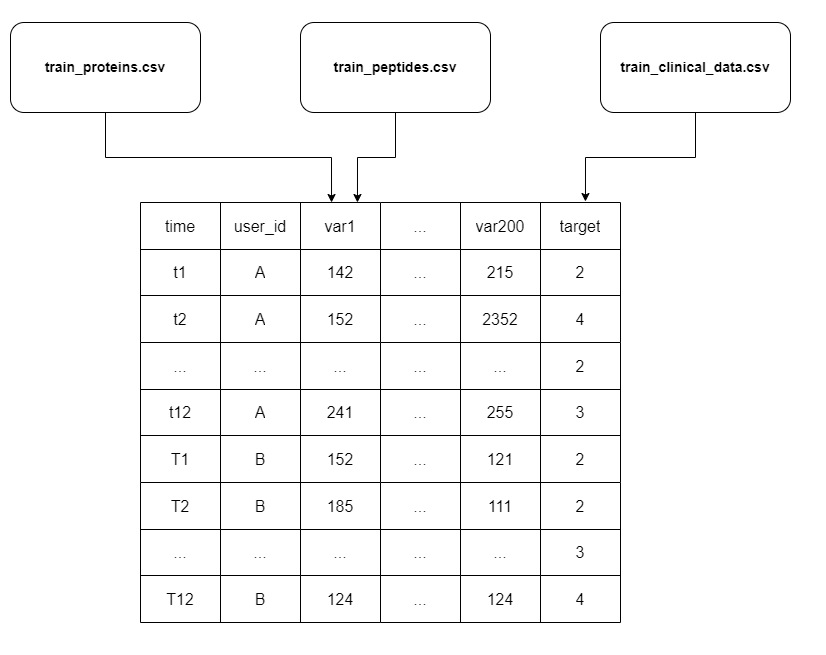


> version1 - 2023.02.17 *created simple dataset without target value

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Data
</p>

**train_peptides.csv Mass spectrometry data at the peptide level. Peptides are the component subunits of proteins.**

* visit_id - ID code for the visit.
* visit_month - The month of the visit, relative to the first visit by the patient.
* patient_id - An ID code for the patient.
* UniProt - The UniProt ID code for the associated protein. There are often several peptides per protein.
* Peptide - The sequence of amino acids included in the peptide. See this table for the relevant codes. Some rare annotations may not be included in the table.
* PeptideAbundance - The frequency of the amino acid in the sample.


**train_proteins.csv Protein expression frequencies aggregated from the peptide level data.**

* visit_id - ID code for the visit.
* visit_month - The month of the visit, relative to the first visit by the patient.
* patient_id - An ID code for the patient.
* UniProt - The UniProt ID code for the associated protein. There are often several peptides per protein.
* NPX - Normalized protein expression. The frequency of the protein's occurrence in the sample. May not have a 1:1 relationship with the component peptides as some proteins contain repeated copies of a given peptide.

**train_clinical_data.csv**

* visit_id - ID code for the visit.
* visit_month - The month of the visit, relative to the first visit by the patient.
* patient_id - An ID code for the patient.
* updrs_[1-4] - The patient's score for part N of the Unified Parkinson's Disease Rating Scale. Higher numbers indicate more severe symptoms. Each sub-section covers a distinct category of symptoms, such as mood and behavior for Part 1 and motor functions for Part 3.
* upd23b_clinical_state_on_medication - Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Libraries</p>

In [1]:
import pandas as pd
import numpy as np

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Brief EDA</p>

<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>EDA summary:</u></b><br>
    
* <i> There are 248 patients in the dataset.</i><br>
* <i> There are 1,113 visit_id, which means each patient visited around 4.48 times on average. This means, on average, each patient has 4~5 records.</i><br>
* <i> There are often several peptides per protein. You should merge peptides dataset to protien.</i><br>
* <i> There are 227 unique UniProt ID, while there are 968 types of peptide. </i><br>    
    
</div>

> dataset summary after combining protiens and peptide dataset.

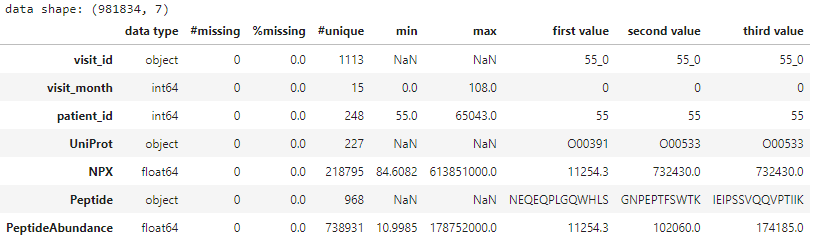

In [2]:
#load dataset
proteins = pd.read_csv("../input/train_proteins.csv")
peptides = pd.read_csv("../input/train_peptides.csv")
clinical = pd.read_csv("../input/train_clinical_data.csv")

In [ ]:
df = proteins
intended_df_size_in_MB = 256
factor = intended_df_size_in_MB*(2**20)/(proteins.memory_usage(index=True).sum()+peptides.memory_usage(index=True).sum()+clinical.memory_usage(index=True).sum())
if int(factor) > 0:
    df = pd.concat([df]*int(factor), ignore_index=True)
else:
    rowCount = int(df.shape[0]*factor)
    df = df[0:rowCount]
proteins = df

df = peptides
if int(factor) > 0:
    df = pd.concat([df]*int(factor), ignore_index=True)
else:
    rowCount = int(df.shape[0]*factor)
    df = df[0:rowCount]
peptides = df
    
df = clinical
if int(factor) > 0:
    df = pd.concat([df]*int(factor), ignore_index=True)
else:
    rowCount = int(df.shape[0]*factor)
    df = df[0:rowCount]
clinical = df

proteins.info()
peptides.info()
clinical.info()

In [3]:
print('proteins shape:             ', proteins.shape)
print('peptides shape:             ', peptides.shape)
print('clinical shape:             ', clinical.shape)

proteins shape:              (232741, 5)
peptides shape:              (981834, 6)
clinical shape:              (2615, 8)


In [4]:
proteins[proteins['patient_id'] == 55]['visit_month'].value_counts()

visit_month
36    224
12    222
0     219
6     218
Name: count, dtype: int64

In [5]:
peptides[peptides['patient_id'] == 55]['visit_month'].value_counts()

visit_month
12    943
6     936
36    936
0     931
Name: count, dtype: int64

> ##### you can see that patient has more than 1 record each time. In order to develop time series model, we need to transform data to the shape that could predict next time's value based on historical data for each patient. 

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Data preprocessing</p>

> #### group by 'visitor_id' and 'UniProt' or 'peptide' and then pivot the dataframe.

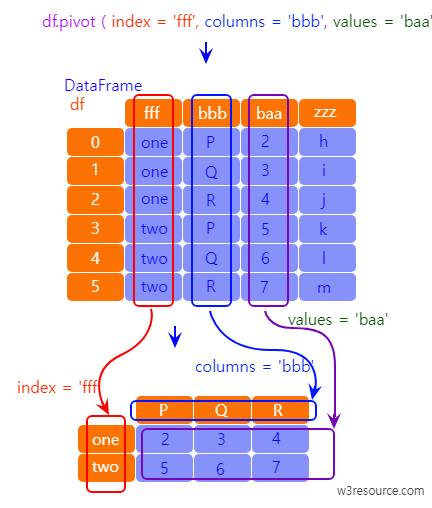

In [6]:
# merge proteins and peptides dataset based on 'visit_id' and 'UniPort'
df_all = proteins.merge(peptides[['visit_id', 'UniProt', 'Peptide','PeptideAbundance']], on = ['visit_id','UniProt'], how = 'left')

In [7]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [8]:
summary(df_all).style.background_gradient(cmap='YlOrBr')

data shape: (981834, 7)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
visit_id,object,0,0.000000,1113,nan,nan,55_0,55_0,55_0
visit_month,int64,0,0.000000,15,0.000000,108.000000,0,0,0
patient_id,int64,0,0.000000,248,55.000000,65043.000000,55,55,55
UniProt,object,0,0.000000,227,nan,nan,O00391,O00533,O00533
NPX,float64,0,0.000000,218795,84.608200,613851000.000000,11254.300000,732430.000000,732430.000000
Peptide,object,0,0.000000,968,nan,nan,NEQEQPLGQWHLS,GNPEPTFSWTK,IEIPSSVQQVPTIIK
PeptideAbundance,float64,0,0.000000,738931,10.998500,178752000.000000,11254.300000,102060.000000,174185.000000


> ##### There's no missing data. So we don't have to consider imputation methods.
> ##### As there's 1,113 unique values for visit_id, this means we will get the datasest with length of 1,113.

In [9]:
# group by uniprot
df_by_uniprot = df_all.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()

In [10]:
# group by peptides
df_by_peptide = df_all.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()

In [11]:
# pivot groupby table for uniprot dataset
df_uniprot = df_by_uniprot.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()

In [12]:
# pivot groupby table for pepdite dataset
df_peptide = df_by_peptide.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()

In [13]:
### let's see how these talbe looks like

In [14]:
df_uniprot.sample(5)

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
299,23391_0,14017.20,484441.0,21143.80,23433.1,22119.8,NaN,109589.0,45572.8,161719.0,...,52032.7,29781.6,107272.0,12522.20,45018.10,191947.0,60258.0,23298.3,25486.7,19732.10
216,1923_24,NaN,804274.0,25747.60,53903.3,16148.9,NaN,236782.0,77984.0,306508.0,...,48289.3,49649.4,141941.0,17107.10,55022.70,511997.0,109431.0,25429.4,21592.3,20110.60
781,5178_48,12948.30,689690.0,33957.10,36804.8,23210.4,1980.56,107845.0,67490.2,206203.0,...,239309.0,34757.8,111193.0,21689.50,39488.20,285471.0,59769.3,NaN,21607.5,17964.20
930,58189_12,NaN,159328.0,6416.57,NaN,NaN,3329.88,42350.4,14512.5,91531.8,...,212173.0,24446.0,NaN,6284.43,2320.66,95251.1,63799.5,NaN,NaN,8815.79
401,27468_72,9908.67,473130.0,29497.90,23180.2,20303.7,2340.17,86134.1,49044.4,210934.0,...,185770.0,36851.2,115666.0,13312.90,34191.40,218028.0,56911.0,23932.0,20860.8,27843.00


In [15]:
df_peptide.sample(5)

,visit_id,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
449,29417_48,12245100.0,NaN,3307980.0,40109.4,11494.6,6368.07,42508.2,463694.0,4525330.0,...,154549.0,NaN,1136040.0,NaN,NaN,78746.0,77656.6,272522.0,NaN,NaN
352,26005_12,4780870.0,51556.6,11519200.0,13735.5,11181.6,66803.40,64663.0,654127.0,4441020.0,...,271356.0,9100.21,8953080.0,84283.3,1619890.0,112015.0,145513.0,174196.0,56031.5,5817.59
1065,64674_84,7083630.0,35656.1,6273100.0,NaN,NaN,15479.20,NaN,32935.4,3112830.0,...,203523.0,3835.58,4901220.0,40325.9,335625.0,49250.4,64076.3,667993.0,38472.5,21949.10
250,20664_0,4892840.0,44753.7,5502100.0,11074.9,14222.7,22615.70,32045.5,436822.0,3608060.0,...,297506.0,NaN,4272340.0,18326.5,254146.0,55446.1,127887.0,583101.0,38552.1,NaN
353,26005_24,11221400.0,36613.2,9994430.0,22693.2,14546.0,56460.90,40155.5,478869.0,6502040.0,...,214303.0,7190.71,11108300.0,99748.9,2029490.0,86081.6,140406.0,513598.0,49210.0,27739.80


In [16]:
# add patient id and visit month
df_uniprot[['patient_id','visit_month']] = df_uniprot.visit_id.str.split("_", expand=True)
df_peptide[['patient_id','visit_month']] = df_peptide.visit_id.str.split("_", expand=True)

> ##### 🗨️ You can use either peptide table or UniProt table. Or, you can find a way to combine it together and discover more information from it.

#### ✔️ Add clinical data

> **MDS UPDRS score sheet** looks like below. **updrs_1** means part I score below.

> Please note that  'upd23b_clinical_state_on_medication' expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.


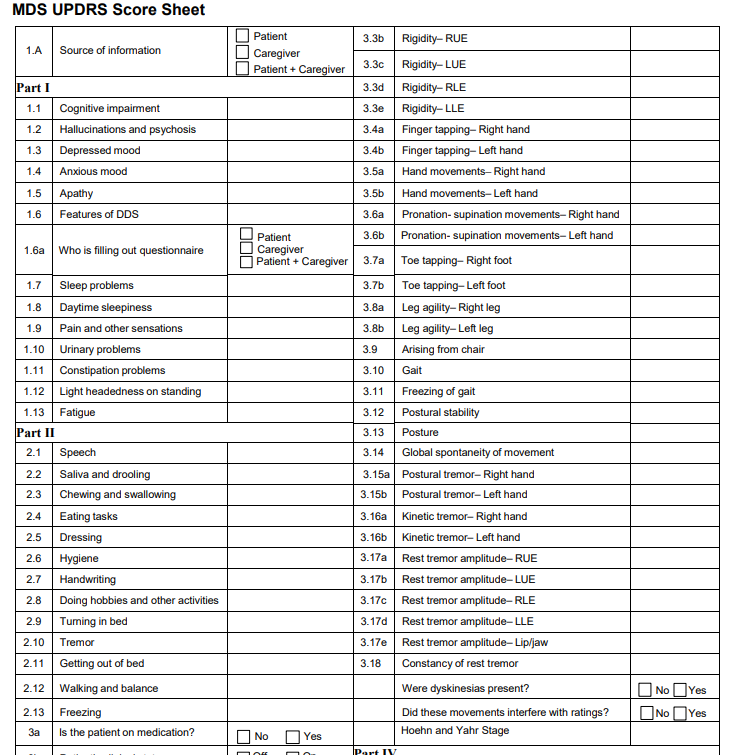

In [17]:
clinical.head(5)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


> ##### 🗨️ use melt function to gather columns into rows (as it is in test dataset)

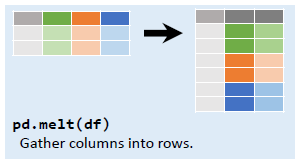

In [18]:
clinical.melt(id_vars=['visit_id', 'patient_id', 'visit_month', 'upd23b_clinical_state_on_medication'], 
                   var_name='updrs', value_name='rating')

,visit_id,patient_id,visit_month,upd23b_clinical_state_on_medication,updrs,rating
0,55_0,55,0,NaN,updrs_1,10.0
1,55_3,55,3,NaN,updrs_1,10.0
2,55_6,55,6,NaN,updrs_1,8.0
3,55_9,55,9,On,updrs_1,8.0
4,55_12,55,12,On,updrs_1,10.0
...,...,...,...,...,...,...
10455,65043_48,65043,48,Off,updrs_4,0.0
10456,65043_54,65043,54,Off,updrs_4,1.0
10457,65043_60,65043,60,Off,updrs_4,1.0
10458,65043_72,65043,72,Off,updrs_4,1.0


In [19]:
# to be continued....